In [39]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time
import math 

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

import pyart

import pytz
# import shap
import pickle
import multiprocessing

import cartopy.crs as ccrs

from sklearn.metrics.pairwise import haversine_distances
from math import radians

RANDOM_STATE = 42

import warnings
warnings.filterwarnings("ignore")

# Perameters


In [40]:
folder = 'spatial'
node_id = '10004098'
dir_out = '../figures/' + folder + '/'
dir_data = '../data/'
dir_NEXRAD = '/Volumes/Backup Plus/NEXRAD/data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1)).astype(str)
for i in range(len(wavelengths)):
    wavelengths[i] = wavelengths[i] + 'nm'
wavelengths = list(wavelengths)

## Read Data

In [34]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + 'driving_' + node_id + '.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')
# df = df[(df.index.date != datetime.date(2020, 2, 14)) # Minolta was covered in these dates
#        &(df.index.date != datetime.date(2020, 2, 21))] 

In [35]:
# add x-y coordinates form the KFWS radar
filename = dir_NEXRAD + '2020-02-10/2020_02_10_KFWS_KFWS20200210_005713_V06'
radar = pyart.io.read_nexrad_archive(filename)

radar_lat = radar.latitude['data'][0]  # 32.57300186
radar_lon = radar.longitude['data'][0] # -97.30314636
projparams = {'proj': 'pyart_aeqd',
              'lon_0': radar_lon,
              'lat_0': radar_lat}

df['x'], df['y'] =  pyart.core.geographic_to_cartesian(df['longitude'], df['latitude'], projparams)


# grid parameters
step = 100 # grid resolution (meter) in x-y plane

z_0, delta_z = 0, 10000
num_z = int(delta_z // 1000) + 1

delta_y , delta_x  = 1000, 1000 # neighbor distance
delta_iy, delta_ix = int(delta_y / step), int(delta_x / step)

# # add weights for Bilinear interpolation of radar data
# df['res_y'], df['res_x'] =  (df['y'] % step) / step,  (df['x'] % step) / step
# df['weight_y0x0'] = (1 - df['res_y']) * (1 - df['res_x'])
# df['weight_y0x1'] = (1 - df['res_y']) *      df['res_x']
# df['weight_y1x0'] =      df['res_y']  * (1 - df['res_x'])
# df['weight_y1x1'] =      df['res_y']  *      df['res_x']

# add nearest of radar data
df['res_y'], df['res_x'] =  (df['y'] % step) / step,  (df['x'] % step) / step
df['add_iy'], df['add_ix'] =  (df['res_y'] > 0.5).astype(int), (df['res_x'] > 0.5).astype(int)

# neighbor parameters
neighbor = {'': (0, 0)}
km_max = 5
for i in range(1,km_max+1): # distance (km)
    neighbor['North_%dkm'          %(i  )] = ( i*delta_iy,           0)
    neighbor['North_%dkm East_%dkm'%(i,i)] = ( i*delta_iy,  i*delta_ix)
    neighbor[           'East_%dkm'%(  i)] = (          0,  i*delta_ix)
    neighbor['South_%dkm East_%dkm'%(i,i)] = (-i*delta_iy,  i*delta_ix)
    neighbor['South_%dkm'          %(i  )] = (-i*delta_iy,           0)
    neighbor['South_%dkm West_%dkm'%(i,i)] = (-i*delta_iy, -i*delta_ix)
    neighbor[           'West_%dkm'%(  i)] = (          0, -i*delta_ix)
    neighbor['North_%dkm West_%dkm'%(i,i)] = ( i*delta_iy, -i*delta_ix)


In [36]:
# date range
dates = np.unique(df.index.date)

# loop parameters
count = 0 # number of data records between the previous 2 radar files

for date in dates:
    yyyy_mm_dd = str(date)
    yyyy = yyyy_mm_dd[:4]
    mm = yyyy_mm_dd[5:7]
    dd = yyyy_mm_dd[-2:]
    
    filenames = os.listdir(dir_NEXRAD + yyyy_mm_dd + '/')
    filenames = [filename for filename in filenames if filename[-1]!= 'M']
    
    for i in range(len(filenames)):
        # find the previous radar datetime
        filename1 = filenames[i]
        HHMMSS1 = filename1[-10:-4]
        HH1, MM1, SS1 = HHMMSS1[:2], HHMMSS1[2:4], HHMMSS1[-2:]
        time1 = datetime.time(int(HH1), int(MM1), int(SS1))
        datetime1 = datetime.datetime.combine(date, time1)
        
        
        # find the next radar datetime
        if i < len(filenames)-1:
            date2 = date
            yyyy_mm_dd2 = str(date2)
            filename2 = filenames[i+1]
        else:
            if count == 0: # skip if the last count == 0
                continue
            # 1st file of the next day
            date2 = date + datetime.timedelta(days = 1)
            yyyy_mm_dd2 = str(date2)
            filenames2 = os.listdir(dir_NEXRAD + yyyy_mm_dd2 + '/')
            for filename2 in filenames2:
                if filename2[-1] != 'M':
                    break
            
        HHMMSS2 = filename2[-10:-4]
        HH2, MM2, SS2 = HHMMSS2[:2], HHMMSS2[2:4], HHMMSS2[-2:]
        time2 = datetime.time(int(HH2), int(MM2), int(SS2))
        datetime2 = datetime.datetime.combine(date2, time2)
        
        
        # check if data exist between this time range
        index_i = (df.index > datetime1) & (df.index <= datetime2)
        count = index_i.sum()
        if count == 0:
            continue
        
        ###################################################################################
        ################# add NEXRAD data between datetime1 and datetime2 #################
        ###################################################################################
        df_i = df[index_i]
        path1 = dir_NEXRAD + yyyy_mm_dd + '/' + filename1
#         path2 = dir_NEXRAD + yyyy_mm_dd2 + '/' + filename2
        
        # read NEXRAD data files
        time_start = time.time()
        radar1 = pyart.io.read_nexrad_archive(path1)
#         radar2 = pyart.io.read_nexrad_archive(path2)
        print(datetime1, '  Reading Time: ', time.time() - time_start, end = ', ')
        
        # set up grid parameters
        y_min, y_max  = (df_i['y'].min() // 100    )* 100 - km_max*delta_y, \
                        (df_i['y'].max() // 100 + 1)* 100 + km_max*delta_y
        x_min, x_max  = (df_i['x'].min() // 100    )* 100 - km_max*delta_x, \
                        (df_i['x'].max() // 100 + 1)* 100 + km_max*delta_x
        
        num_y = int((y_max - y_min) // 100) + 1
        num_x = int((x_max - x_min) // 100) + 1
        
        time_start = time.time()
        grid1 = pyart.map.grid_from_radars(radar1, grid_shape=(num_z, num_y, num_x),\
                                           grid_limits=((z_0, z_0 + delta_z), (y_min, y_max), (x_min, x_max)))
#         grid2 = pyart.map.grid_from_radars(radar2, grid_shape=(num_z, num_y, num_x),\
#                                            grid_limits=((z_0, z_0 + delta_z), (y_min, y_max), (x_min, x_max)))
        
        fields1 = grid1.fields['reflectivity']['data'].filled(fill_value=np.nan)
#         fields1 = grid1.fields['reflectivity']['data'].filled(fill_value=-33)
#         fields2 = grid2.fields['reflectivity']['data'].filled(fill_value=-33)
        print('Griding Time: ', time.time() - time_start, end = ', ')
        
        # add NEXRAD data into dataframe
        time_start = time.time()
#         datetime_interval = datetime2 - datetime1
#         df_i.loc[:,'weight_t1'] = (datetime2 - df_i.index) / datetime_interval
#         df_i.loc[:,'weight_t2'] = (df_i.index - datetime1) / datetime_interval

        iy = ((df_i.loc[:,'y'] - y_min)//100).astype(int) + df_i.loc[:,'add_iy']
        ix = ((df_i.loc[:,'x'] - x_min)//100).astype(int) + df_i.loc[:,'add_ix']
#         iy = ((df_i.loc[:,'y'] - y_min)//100).astype(int) + df_i.loc[:,'add_iy']
#         ix = ((df_i.loc[:,'x'] - x_min)//100).astype(int) + df_i.loc[:,'add_ix']

        for iz in range(num_z):
            for direction in neighbor:
                var = 'Reflectivity Level_%dkm' % (iz)
                if direction:
                    var += ' ' + direction
                diy, dix = neighbor[direction]
                
                # take nearest value
                df.loc[index_i,var] = fields1[iz, iy+diy, ix+dix]
                
#                 val_t2  = df_i.loc[:,'weight_y0x0'] * fields1[iz, iy+diy  , ix+dix  ] \
#                         + df_i.loc[:,'weight_y0x1'] * fields1[iz, iy+diy  , ix+dix+1] \
#                         + df_i.loc[:,'weight_y1x0'] * fields1[iz, iy+diy+1, ix+dix  ] \
#                         + df_i.loc[:,'weight_y1x1'] * fields1[iz, iy+diy+1, ix+dix+1] \

#                 val_t2  = df_i.loc[:,'weight_y0x0'] * fields2[iz, iy+diy  , ix+dix  ] \
#                         + df_i.loc[:,'weight_y0x1'] * fields2[iz, iy+diy  , ix+dix+1] \
#                         + df_i.loc[:,'weight_y1x0'] * fields2[iz, iy+diy+1, ix+dix  ] \
#                         + df_i.loc[:,'weight_y1x1'] * fields2[iz, iy+diy+1, ix+dix+1] \

#                 df.loc[index_i,var] =  df_i.loc[:,'weight_t1'] * val_t1.loc[:] \ 
#                                     +  df_i.loc[:,'weight_t2'] * val_t2.loc[:]
# 
        print('Inserting Time: ', time.time() - time_start)
#         break
#     break

2020-01-08 16:42:53   Reading Time:  2.2978579998016357, Griding Time:  3.726614236831665, Inserting Time:  0.4820868968963623
2020-01-08 16:49:45   Reading Time:  2.1703057289123535, Griding Time:  3.8762362003326416, Inserting Time:  0.23862719535827637
2020-01-08 16:56:48   Reading Time:  2.2072927951812744, Griding Time:  4.031988143920898, Inserting Time:  0.2233719825744629
2020-01-08 17:03:38   Reading Time:  2.2081100940704346, Griding Time:  3.946315050125122, Inserting Time:  0.24211907386779785
2020-01-08 17:10:37   Reading Time:  2.1934311389923096, Griding Time:  4.2034618854522705, Inserting Time:  0.24855995178222656
2020-01-08 17:17:36   Reading Time:  2.2165839672088623, Griding Time:  4.275774955749512, Inserting Time:  0.23663997650146484
2020-01-08 17:24:36   Reading Time:  2.981520891189575, Griding Time:  3.9864120483398438, Inserting Time:  0.22894811630249023
2020-01-08 17:31:34   Reading Time:  2.0783731937408447, Griding Time:  3.903857946395874, Inserting Tim

2020-01-24 17:46:21   Reading Time:  2.059370994567871, Griding Time:  3.972885847091675, Inserting Time:  0.2349848747253418
2020-01-24 17:53:11   Reading Time:  2.0390028953552246, Griding Time:  4.1497962474823, Inserting Time:  0.23314690589904785
2020-01-24 18:00:06   Reading Time:  2.0515048503875732, Griding Time:  3.7330501079559326, Inserting Time:  0.22233200073242188
2020-01-24 18:07:04   Reading Time:  2.188528060913086, Griding Time:  3.9089431762695312, Inserting Time:  0.22834110260009766
2020-01-24 18:13:55   Reading Time:  2.10079288482666, Griding Time:  4.260498285293579, Inserting Time:  0.2341618537902832
2020-01-24 18:20:54   Reading Time:  3.112133026123047, Griding Time:  3.442208766937256, Inserting Time:  0.22875523567199707
2020-01-24 18:27:44   Reading Time:  1.9696869850158691, Griding Time:  3.4327480792999268, Inserting Time:  0.22768378257751465
2020-01-24 18:34:36   Reading Time:  2.0669848918914795, Griding Time:  3.4063608646392822, Inserting Time:  0

2020-01-31 19:19:16   Reading Time:  2.1085782051086426, Griding Time:  3.885309934616089, Inserting Time:  0.2244701385498047
2020-01-31 19:26:05   Reading Time:  2.1057350635528564, Griding Time:  3.7073540687561035, Inserting Time:  0.23111605644226074
2020-01-31 19:32:55   Reading Time:  2.1553540229797363, Griding Time:  3.7605199813842773, Inserting Time:  0.22372198104858398
2020-01-31 19:39:54   Reading Time:  2.8585331439971924, Griding Time:  3.3872740268707275, Inserting Time:  0.23491287231445312
2020-01-31 19:46:45   Reading Time:  1.954153060913086, Griding Time:  3.2368571758270264, Inserting Time:  0.22414731979370117
2020-01-31 19:53:41   Reading Time:  1.93696928024292, Griding Time:  3.293837070465088, Inserting Time:  0.22275686264038086
2020-01-31 20:00:37   Reading Time:  2.015983819961548, Griding Time:  3.345046043395996, Inserting Time:  0.22626209259033203
2020-01-31 20:07:27   Reading Time:  2.0090489387512207, Griding Time:  3.5437021255493164, Inserting Tim

2020-02-10 19:46:00   Reading Time:  3.124624013900757, Griding Time:  4.154794931411743, Inserting Time:  0.23169589042663574
2020-02-10 19:49:45   Reading Time:  3.051546096801758, Griding Time:  4.539094924926758, Inserting Time:  0.22553205490112305
2020-02-10 19:53:17   Reading Time:  3.118041753768921, Griding Time:  4.219209909439087, Inserting Time:  0.22303009033203125
2020-02-10 19:56:49   Reading Time:  3.954024076461792, Griding Time:  3.7357852458953857, Inserting Time:  0.2228243350982666
2020-02-10 20:00:22   Reading Time:  3.0984110832214355, Griding Time:  3.914454936981201, Inserting Time:  0.22840404510498047
2020-02-10 20:04:08   Reading Time:  2.8732306957244873, Griding Time:  3.916107177734375, Inserting Time:  0.22243380546569824
2020-02-10 20:07:40   Reading Time:  2.900078296661377, Griding Time:  3.8549211025238037, Inserting Time:  0.22223210334777832
2020-02-10 20:11:11   Reading Time:  2.9335720539093018, Griding Time:  3.8754348754882812, Inserting Time: 

2020-02-11 21:17:18   Reading Time:  3.813762903213501, Griding Time:  5.315202951431274, Inserting Time:  0.22460699081420898
2020-02-11 21:21:32   Reading Time:  3.8101449012756348, Griding Time:  5.05608606338501, Inserting Time:  0.22298908233642578
2020-02-11 21:25:47   Reading Time:  3.7671070098876953, Griding Time:  5.013007879257202, Inserting Time:  0.23203110694885254
2020-02-11 21:30:00   Reading Time:  4.8347978591918945, Griding Time:  4.381644010543823, Inserting Time:  0.22435474395751953
2020-02-11 21:34:14   Reading Time:  3.6398768424987793, Griding Time:  4.426609992980957, Inserting Time:  0.22430109977722168
2020-02-11 21:38:28   Reading Time:  3.6186821460723877, Griding Time:  4.468241930007935, Inserting Time:  0.2242429256439209
2020-02-11 21:42:43   Reading Time:  3.597761869430542, Griding Time:  4.549584865570068, Inserting Time:  0.22303509712219238
2020-02-11 21:46:58   Reading Time:  3.6370840072631836, Griding Time:  4.550577878952026, Inserting Time:  

2020-04-20 14:57:44   Reading Time:  2.0786702632904053, Griding Time:  4.8942811489105225, Inserting Time:  0.23465800285339355
2020-04-20 15:04:53   Reading Time:  2.0438687801361084, Griding Time:  4.776631116867065, Inserting Time:  0.23657870292663574
2020-04-20 15:12:04   Reading Time:  2.082737922668457, Griding Time:  3.8932149410247803, Inserting Time:  0.24086570739746094
2020-04-20 15:19:03   Reading Time:  2.082195997238159, Griding Time:  3.679827928543091, Inserting Time:  0.2305469512939453
2020-04-20 15:25:52   Reading Time:  2.1041617393493652, Griding Time:  3.6623129844665527, Inserting Time:  0.2376561164855957
2020-04-20 15:33:02   Reading Time:  2.169816732406616, Griding Time:  4.393003940582275, Inserting Time:  0.23424530029296875
2020-04-20 15:40:12   Reading Time:  2.126559019088745, Griding Time:  4.209414005279541, Inserting Time:  0.23314213752746582
2020-04-20 15:47:21   Reading Time:  3.0969672203063965, Griding Time:  3.7334342002868652, Inserting Time:

In [37]:
# save merged data
df.to_csv(dir_data + 'driving_' + node_id + '_NEXRAD_'+str(km_max)+'km.csv')

## Visualization

In [95]:
filename = dir_NEXRAD + '2020-02-10/2020_02_10_KFWS_KFWS20200210_172020_V06'
radar = pyart.io.read_nexrad_archive(filename)

grid = pyart.map.grid_from_radars(radar, grid_shape=(num_z, 100, 100),\
                                grid_limits=((z_0, z_0 + delta_z), (df['y'].min(), df['y'].max()), (df['x'].min(), df['x'].max())))


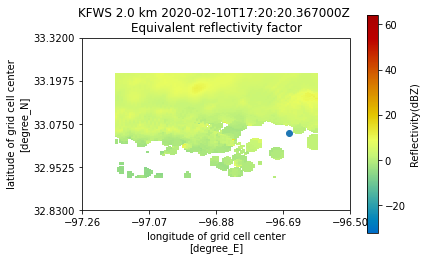

In [96]:
fig = plt.figure(figsize=[6,4])
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('reflectivity', level=2, vmin=-32, vmax=64)
plt.scatter([-96.67352], [33.048915])


In [ ]:
filename = dir_NEXRAD + '2020-02-01/2020_02_01_KFWS_KFWS20200201_202954_V06'
radar = pyart.io.read_nexrad_archive(filename)

grid = pyart.map.grid_from_radars(radar, grid_shape=(num_z, 100, 100),\
                                grid_limits=((z_0, z_0 + delta_z), (df['y'].min(), df['y'].max()), (df['x'].min(), df['x'].max())))



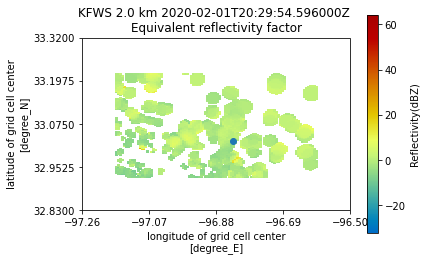

In [93]:
fig = plt.figure(figsize=[6,4])
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('reflectivity', level=2, vmin=-32, vmax=64)
plt.scatter([-96.831739], [33.02636])


## Driving Temporal Variogram

In [6]:
var = 'Illuminance'
dh = 20

for date in set(df.index.date):    
    df1 = df[df.index.date == date]
    h = np.array([])
    variance = np.array([])
    for i in range(len(df1)):
        if i % 1000 == 0:
            print(i)
        ti = df1.index[i]
        f = df1.iloc[i][var]
    
        # distance in seconds
        h1 = abs(df1.index - df1.index[i]).seconds

        # variances before square root
        variance1 = (df1[var] - f).values**2

        # filter in time window (hours)

        h = np.append(h, h1)
        variance = np.append(variance, variance1)

    if len(gamma_day):
        h_day = np.array([])
        gamma_day = np.array([])
        dt_day = np.array([])
        for h_left in np.arange(0, h1.max()/50, dh):
            h_i = h_left + dh/2
            h_right = h_left + dh

            iwant = (h >= h_left) & (h < h_right)
            gamma_i = np.sqrt(variance[iwant].mean())

            h_day = np.append(h_day, h_i)
            gamma_day = np.append(gamma_day, gamma_i)

        plt.figure(figsize=(8, 6))
        plt.rcParams.update({'font.size': 15})
        plt.scatter(h_day, gamma_day,  s = 20)
        plt.xlabel('h / s')
        plt.ylabel('$\gamma$')
        plt.title('Variogram: ' + str(date) +  '\nrolling average by '+ str(dh)+ ' seconds ')
        plt.xlim(0,h_day.max())
        plt.ylim(0,np.nanmax(gamma_day)*1.1)
        plt.savefig(dir_out+'variogram_t_%02d_%02d_%02d_avg_%02ds.png' % (date.year, date.month, date.day, dh ))
        plt.close()

0


NameError: name 'gamma_day' is not defined

## Spatial Variogram

In [8]:
h = np.array([])
variance = np.array([])
deltaT = np.array([])
for i in range(len(df1)):
    if i % 1000 == 0:
        print(i)
    long = df1.iloc[i]['longitude']
    lat = df1.iloc[i]['latitude']
    f = df1.iloc[i][var]
    
    # dx = dlong* cos lat
    dx = (df1['longitude'] - long).apply(math.radians) * np.cos(math.radians(df1['latitude'].mean()))
    # dy = dlat
    dy = (df1['latitude'] - lat).apply(math.radians)
    # ds = R*sqrt(dx^2 + dy^2)
    # distance in meters
    h1 = R*np.sqrt(dx*dx + dy*dy)
    
    # variances before square root
    variance1 = (df1[var] - f).values**2
    
    # filter in time window (hours)
    deltaT1 = abs(h1.index - df1.index[i])
    iwant = deltaT1 < datetime.timedelta(hours=0.5)
    
    h = np.append(h, h1[iwant])
    variance = np.append(variance, variance1[iwant])
    deltaT = np.append(deltaT, deltaT1[iwant].seconds)
    

0


NameError: name 'R' is not defined

In [7]:
for dh in [5,10,20,30,40,50,60,70,80,90,100]:
    h_day = np.array([])
    gamma_day = np.array([])
    dt_day = np.array([])
    for h_left in np.arange(0, h1.max(), dh):
        h_i = h_left + dh/2
        h_right = h_left + dh

        iwant = (h>=h_left) & (h < h_right)
        gamma_i = np.sqrt(variance[iwant].mean())

        h_day = np.append(h_day, h_i)
        gamma_day = np.append(gamma_day, gamma_i)

    plt.figure(figsize=(12, 10))
    plt.rcParams.update({'font.size': 15})
    plt.scatter(h_day, gamma_day,  s = 5)
    plt.xlabel('h / m')
    plt.ylabel('$\gamma$')
    plt.title('Variogram: ' + str(date) +  '\nrolling average by '+ str(dh)+ ' meters ')
    plt.xlim(0,6000)
    plt.ylim(0,5000)
    plt.savefig(dir_out+'variogram_%02d_%02d_%02d_avg_%02dm.png' % (date.year, date.month, date.day, dh ))
    plt.close()

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/Users/Strawberry/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [195]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 15})
plt.scatter(h_day, gamma_day,  s = 5, c = dt_day)
plt.xlabel('h / m')
plt.ylabel('$\gamma$')
plt.title('Variogram: ' + str(date) +  '\nrolling average by '+ str(dh)+ ' meters ')
plt.ylim(0,5000)
plt.legend( loc='lower right')
plt.savefig(dir_out+'variogram_%02d_%02d_%02d_avg_%02dm.png' % (date.year, date.month, date.day, dh ))
plt.close()

No handles with labels found to put in legend.


In [9]:
# variogram each day
R = 6371 * 1000 # radius of earth

h = np.array([])
variance = np.array([])
for date in set(df.index.date):
    df1 = df[df.index.date == date]
    if df1['longitude'].std() < 1E-4:
        continue
    
    print(date,len(df1))
    h = np.array([])
    variance = np.array([])
    for i in range(len(df1)):
        if i % 1000 == 0:
            print(i)
        long = df1.iloc[i]['longitude']
        lat = df1.iloc[i]['latitude']
        f = df1.iloc[i][var]
        # dx = dlong* cos lat
        dx = (df1['longitude'] - long).apply(math.radians) * np.cos(math.radians(df1['latitude'].mean()))
        # dy = dlat
        dy = (df1['latitude'] - lat).apply(math.radians)
        # ds = R*sqrt(dx^2 + dy^2)
        
        h1 = R*np.sqrt(dx*dx + dy*dy)
        variance1 = (df1[var] - f).values**2

        h = np.append(h, h1)
        variance = np.append(variance, variance1)
    
    break
    

2020-01-23 680
0


In [194]:
np.cos(math.radians(df1['latitude'].mean()))

0.8385263740005442

20

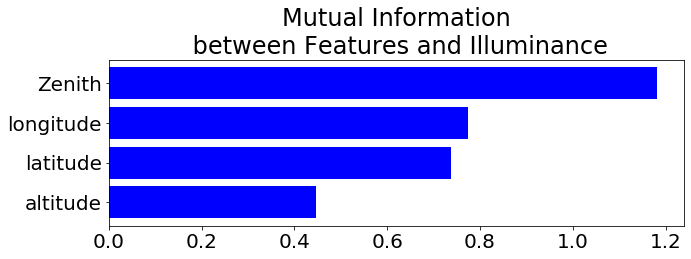

In [78]:
# rank feature inportance
num_features = len(features)
#std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(MIs)[::-1]

var_sorted = features[indices]
MIs_sorted = MIs[indices]

plt.rcParams["figure.figsize"] = (10, num_features) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
ax.barh(var_sorted[:num_features],
        MIs_sorted[:], color = 'blue',
        #yerr=std[indices][:num_features], ecolor='black',
        align="center")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Mutual Information\n between Features and Illuminance')
plt.tight_layout()
plt.savefig(dir_out + target + '/Mutual_Information_Illuminance.png')

In [88]:
# EM
Cluster = 'EM'
em = GaussianMixture(n_components=n_components)
em.fit(X_PCA)
y_em = em.predict(X_PCA)
#centers = em.cluster_centers_
scatter(X_PCA,  X_PCA.columns[0], X_PCA.columns[1],  y_em)

# export EM data
df_DR_Cluster = df_DR.copy() 
df_DR_Cluster['Cluster'] = y_em
df_DR_Cluster[target] = y_train_scaled

#df_DR_Cluster.to_csv(dir_in + 'heart_'+ DR + '_' + Cluster +'.csv', index = False)


In [ ]:
# one-hot encoding
onehot_vars = ['Cluster']
for var in onehot_vars:
    df_add = pd.get_dummies(df_DR_Cluster[[var]].astype(str),prefix=[var], drop_first=True)
    df = pd.concat([df, df_add], axis=1)

df.drop(onehot_vars, axis=1, inplace=True)

# move target to the last column
df_target = df.pop('target') 
df['target'] = df_target

In [90]:
#hidden_layer_sizes=(32,64,128)
hidden_layer_sizes=(64,128,256)#
#hidden_layer_sizes=(128,128,128,128)
#hidden_layer_sizes=(150)
activation ='relu'
solver = 'adam'
alpha=1e-5 # L2 penalty (regularization term) parameter, default 1e-5
learning_rate = 'constant'

# include layer structure and activation function
structure = '_' + DR + str(n_components) + \
            '_' + str(hidden_layer_sizes)[1:-1].replace(', ','_') + \
            '_' + activation

In [42]:
start_time = time.time()


regr = MLPRegressor(random_state = RANDOM_STATE,
                    hidden_layer_sizes = hidden_layer_sizes,
                    activation = activation,
                    solver = solver,
                    alpha = alpha,
                    learning_rate = learning_rate,
                    verbose = True
                    )
regr.fit(X_train_scaled_DR_scaled, y_train_scaled)

# fine tune the model
regr.warm_start = True
regr.learning_rate_init /= 10 # default 0.001
regr.fit(X_train_scaled_DR_scaled, y_train_scaled)

regr.learning_rate_init /= 10 # default 0.001
regr.fit(X_train_scaled_DR_scaled, y_train_scaled)

print("--- %s seconds ---" % (time.time() - start_time))

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.24978304
Iteration 2, loss = 0.19766890
Iteration 3, loss = 0.18686484
Iteration 4, loss = 0.17985114
Iteration 5, loss = 0.17700322
Iteration 6, loss = 0.17277917
Iteration 7, loss = 0.16807567
Iteration 8, loss = 0.16515572
Iteration 9, loss = 0.16163736
Iteration 10, loss = 0.16254459
Iteration 11, loss = 0.15741617
Iteration 12, loss = 0.15371796
Iteration 13, loss = 0.14991794
Iteration 14, loss = 0.14903290
Iteration 15, loss = 0.14416498
Iteration 16, loss = 0.14437645
Iteration 17, loss = 0.14167055
Iteration 18, loss = 0.14014031
Iteration 19, loss = 0.13835518
Iteration 20, loss = 0.13468058
Iteration 21, loss = 0.13468341
Iteration 22, loss = 0.13261491
Iteration 23, loss = 0.13181999
Iteration 24, loss = 0.12880940
Iteration 25, loss = 0.12779694
Iteration 26, loss = 0.12384032
Iteration 27, loss = 0.12309710
Iteration 28, loss = 0.12328653
Iteration 29, loss = 0.12492425
Iteration 30, loss = 0.12093945
Iteration 31, loss = 0.12050412
Iteration 32, los

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Strawberry/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 201, loss = 0.06046424
Iteration 202, loss = 0.05823911
Iteration 203, loss = 0.05800048
Iteration 204, loss = 0.05781358
Iteration 205, loss = 0.05765320
Iteration 206, loss = 0.05751840
Iteration 207, loss = 0.05741285
Iteration 208, loss = 0.05729673
Iteration 209, loss = 0.05715286
Iteration 210, loss = 0.05749360
Iteration 211, loss = 0.05709018
Iteration 212, loss = 0.05696343
Iteration 213, loss = 0.05698680
Iteration 214, loss = 0.05684813
Iteration 215, loss = 0.05680614
Iteration 216, loss = 0.05684098
Iteration 217, loss = 0.05680747
Iteration 218, loss = 0.05674410
Iteration 219, loss = 0.05663876
Iteration 220, loss = 0.05659056
Iteration 221, loss = 0.05657127
Iteration 222, loss = 0.05645306
Iteration 223, loss = 0.05662800
Iteration 224, loss = 0.05655155
Iteration 225, loss = 0.05632543
Iteration 226, loss = 0.05628983
Iteration 227, loss = 0.05628233
Iteration 228, loss = 0.05623468
Iteration 229, loss = 0.05634472
Iteration 230, loss = 0.05617977
Iteration 

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 314, loss = 0.05237504
Iteration 315, loss = 0.05214596
Iteration 316, loss = 0.05209610
Iteration 317, loss = 0.05204638
Iteration 318, loss = 0.05204958
Iteration 319, loss = 0.05203741
Iteration 320, loss = 0.05203714
Iteration 321, loss = 0.05201560
Iteration 322, loss = 0.05201285
Iteration 323, loss = 0.05205316
Iteration 324, loss = 0.05201425
Iteration 325, loss = 0.05199157
Iteration 326, loss = 0.05201714
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
--- 189.56539583206177 seconds ---


In [43]:
# save model
dir_model = '../models/' + folder + '/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)
dir_model +=  target + '/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)

fn_model = dir_model + target + structure + '.sav'
pickle.dump(regr, open(fn_model, 'wb'))


In [ ]:
# dir_model = '../models/' + folder + '/' + target + '/'
# fn_model = dir_model + target + structure + '.sav'
# regr = pickle.load(open(fn_model, 'rb'))

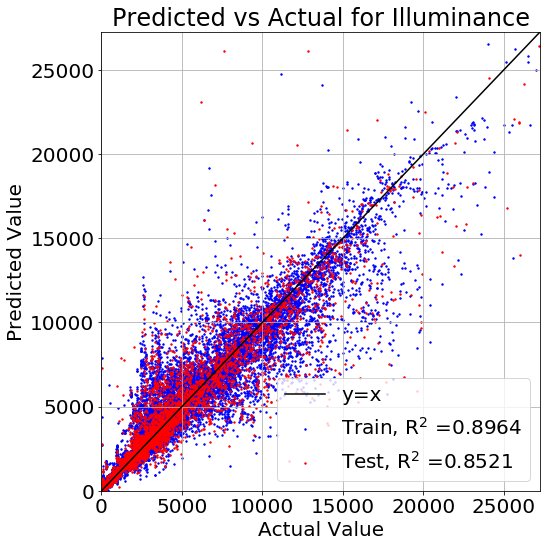

In [49]:
y_train_pred = scaler_y.inverse_transform(\
                    regr.predict( X_train_scaled_DR_scaled ).reshape(-1,1)
                    ) # for train
y_test_pred = scaler_y.inverse_transform(\
                    regr.predict( X_test_scaled_DR_scaled ).reshape(-1,1)
                    ) # for image

train_score =  r2_score(y_train, y_train_pred)
test_score = r2_score(y_test, y_test_pred)

y_min = 0
y_max = np.amax(y_train.values)*0.6
y_line = np.linspace(y_min,y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')
plt.scatter(y_train,y_train_pred, s=2, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
plt.scatter(y_test,y_test_pred, s=2, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim((y_min,y_max))
plt.ylim((y_min,y_max))
ax.set_title('Predicted vs Actual for ' + target)
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + target):
    os.mkdir(dir_out + target)
plt.savefig(dir_out + target +'/MLP_performance_'+target+structure+'.png')


In [45]:
y_max

45418.560547

In [10]:
df.columns

Index(['Illuminance', '360nm', '361nm', '362nm', '363nm', '364nm', '365nm',
       '366nm', '367nm', '368nm',
       ...
       '775nm', '776nm', '777nm', '778nm', '779nm', '780nm', 'Zenith',
       'latitude', 'longitude', 'altitude'],
      dtype='object', length=426)

In [10]:
temp = df['latitude'].values.min()
print(temp)
temp//1,(temp%1)*60//1, ((temp%1)*60)%1*60//1

32.923808333333334


(32.0, 55.0, 25.0)

In [11]:
temp = df['latitude'].values.max()
print(temp)
temp//1,(temp%1)*60//1, ((temp%1)*60)%1*60//1

33.21573566666666


(33.0, 12.0, 56.0)

In [12]:
temp = df['longitude'].values.min()
print(temp)
temp//1,(temp%1)*60//1, ((temp%1)*60)%1*60//1

96.59482766666667


(96.0, 35.0, 41.0)

In [13]:
temp = df['longitude'].values.max()
print(temp)
temp//1,(temp%1)*60//1, ((temp%1)*60)%1*60//1

97.161448


(97.0, 9.0, 41.0)

In [ ]:
#  32.5,  33.5
# -97.5, -96.5



In [15]:
(96.59482766666667 + 97.161448)/2, (32.923808333333334+33.21573566666666)/2


(96.87813783333334, 33.069772)

## Google Earth Engine

In [ ]:
var geometry = 
    /* color: #d68480 */
    /* displayProperties: [
      {
        "type": "rectangle"
      }
    ] */
    ee.Geometry.Polygon(
        [[[-97.161448, 32.923808333333334],
          [-97.161448, 33.21573566666666],
          [-96.59482766666667, 33.21573566666666],
          [-96.59482766666667, 32.923808333333334]]], null, false);

In [ ]:
/**
 * Function to mask clouds based on the pixel_qa band of Landsat 8 SR data.
 * @param {ee.Image} image input Landsat 8 SR image
 * @return {ee.Image} cloudmasked Landsat 8 image
 */
function maskL8sr(image) {
  // Bits 3 and 5 are cloud shadow and cloud, respectively.
  var cloudShadowBitMask = (1 << 3);
  var cloudsBitMask = (1 << 5);
  // Get the pixel QA band.
  var qa = image.select('pixel_qa');
  // Both flags should be set to zero, indicating clear conditions.
  var mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0)
                 .and(qa.bitwiseAnd(cloudsBitMask).eq(0));
  return image.updateMask(mask);
}

var dataset = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
                  .filterDate('2020-01-25', '2020-02-10')
                  .filterBounds(geometry)
                  .map(maskL8sr);

var visParams = {
  bands: ['B4', 'B3', 'B2'],
  min: 0,
  max: 3000,
  gamma: 1.4,
};
Map.setCenter(-96.87813783333334, 33.069772, 9);
Map.addLayer(dataset.median(), visParams);


Export.image.toDrive({
  image:dataset.median(),
  description:"landsat8",
  scale:30,
  region:geometry
});


In [30]:
set(df.index.date)

{datetime.date(2020, 1, 8),
 datetime.date(2020, 1, 9),
 datetime.date(2020, 1, 15),
 datetime.date(2020, 1, 16),
 datetime.date(2020, 1, 17),
 datetime.date(2020, 1, 23),
 datetime.date(2020, 1, 24),
 datetime.date(2020, 1, 25),
 datetime.date(2020, 1, 26),
 datetime.date(2020, 1, 27),
 datetime.date(2020, 1, 28),
 datetime.date(2020, 1, 29),
 datetime.date(2020, 1, 30),
 datetime.date(2020, 1, 31),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 3),
 datetime.date(2020, 2, 7),
 datetime.date(2020, 2, 8),
 datetime.date(2020, 2, 9),
 datetime.date(2020, 2, 10),
 datetime.date(2020, 2, 11),
 datetime.date(2020, 2, 12),
 datetime.date(2020, 2, 13),
 datetime.date(2020, 2, 14),
 datetime.date(2020, 2, 15),
 datetime.date(2020, 2, 16),
 datetime.date(2020, 2, 17),
 datetime.date(2020, 2, 18),
 datetime.date(2020, 2, 19),
 datetime.date(2020, 2, 20),
 datetime.date(2020, 2, 21),
 datetime.date(2020, 2, 22),
 datetime.date(2020, 2, 23),
 datetime.date(2020, 2

In [31]:
datetime.date(2020, 1, 8),
# datetime.date(2020, 1, 15),
# datetime.date(2020, 1, 16),
datetime.date(2020, 1, 23),
datetime.date(2020, 1, 24),
# datetime.date(2020, 1, 30),
# datetime.date(2020, 1, 31),
datetime.date(2020, 2, 1),
datetime.date(2020, 2, 7),
# datetime.date(2020, 2, 8),
# datetime.date(2020, 2, 15),
# datetime.date(2020, 2, 16),
# datetime.date(2020, 2, 17),
# datetime.date(2020, 2, 24),
# datetime.date(2020, 2, 25),
# datetime.date(2020, 3, 18),
# datetime.date(2020, 3, 20),
# datetime.date(2020, 3, 26),
# datetime.date(2020, 3, 27),


(datetime.date(2020, 2, 7),)

In [19]:
fn_data = dir_data + 'LC08_CU_016014_20200114_20200129_C01_V01_SRB1.tif'

from PIL import Image
im = Image.open(fn_data)
im.show()

In [20]:
imarray = np.array(im)

In [21]:
imarray

array([[  469,   522,   664, ..., -9999, -9999, -9999],
       [  606,   427,   555, ..., -9999, -9999, -9999],
       [  708,   529,   632, ..., -9999, -9999, -9999],
       ...,
       [ 4835,  4840,  4783, ..., -9999, -9999, -9999],
       [ 4899,  4858,  4782, ..., -9999, -9999, -9999],
       [ 4935,  4917,  4860, ..., -9999, -9999, -9999]], dtype=int32)

(-584.8977731768597, 539.2639856384162, -312.2922078692653, 312.0552681765916)

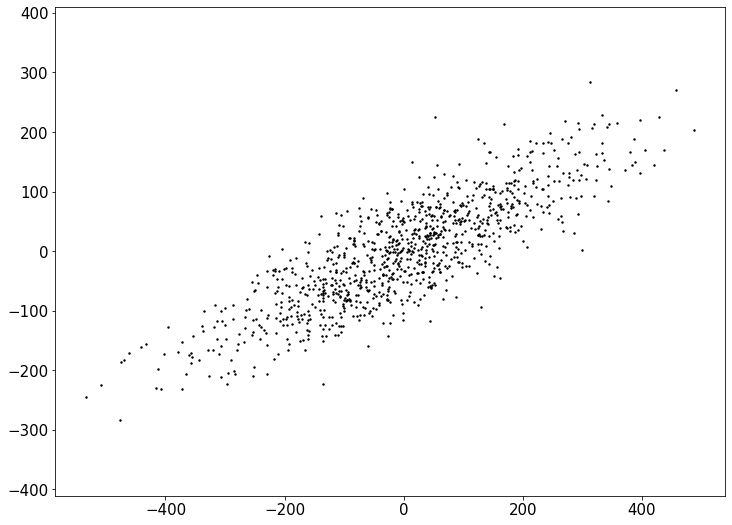

In [66]:
# PCA
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
plt.rcParams.update({'font.size': 15})

x0 = np.random.normal(0, 80, 1000)
y0 = np.random.normal(0, 20, 1000)

x1 = 2*x0 + y0
y1 = x0 - 2*y0

plt.scatter(x1,y1, 2, 'k')

plt.axis('equal')

(-780.9993556536605, 826.2922795296637, -309.4631267685153, 309.4631267685153)

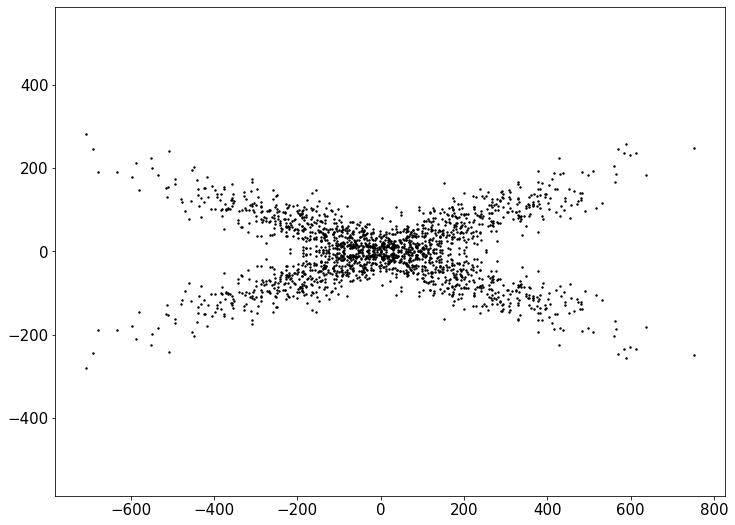

In [59]:
# ICA
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
plt.rcParams.update({'font.size': 15})

x0 = np.random.normal(0, 80, 1000)
y0 = np.random.normal(0, 10, 1000)

x1 = 3*x0 + y0
y1 = x0 - 3*y0

x2 = x1
y2 = -y1

plt.scatter(x1,y1, 2, 'k')
plt.scatter(x2,y2, 2, 'k')

plt.axis('equal')